# Imports

In [488]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.cluster import DBSCAN
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

random_state = 42

# Reading

In [405]:
df = pd.read_sas('a2z_insurance.sas7bdat')
df['CustID'] = df['CustID'].astype('int')
df = df.set_index('CustID')

print('Dataframe shape:', df.shape)

Dataframe shape: (10296, 13)


In [406]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10296 entries, 1 to 10296
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FirstPolYear   10266 non-null  float64
 1   BirthYear      10279 non-null  float64
 2   EducDeg        10279 non-null  object 
 3   MonthSal       10260 non-null  float64
 4   GeoLivArea     10295 non-null  float64
 5   Children       10275 non-null  float64
 6   CustMonVal     10296 non-null  float64
 7   ClaimsRate     10296 non-null  float64
 8   PremMotor      10262 non-null  float64
 9   PremHousehold  10296 non-null  float64
 10  PremHealth     10253 non-null  float64
 11  PremLife       10192 non-null  float64
 12  PremWork       10210 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.1+ MB


In [407]:
df.head()

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
1,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
2,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
3,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
4,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
5,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


# Data Preparation

In [408]:
numerical_col_list = ['FirstPolYear', 'BirthYear', 'MonthSal', 'CustMonVal', 
                'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth',
                'PremLife', 'PremWork']
categorical_col_list = ['EducDeg', 'GeoLivArea','Children'] 
ordinal_col_list = ['EducDeg']
nominal_col_list = ['GeoLivArea','Children']

## Data wrangling

In [409]:
# Fix EducDeg column value

def educDegtransform(row):
    row = row.decode("utf-8") if type(row) == bytes else row 
    if type(row) == str:
        educ_dict = {
            '1 - Basic': 1,
            '2 - High School': 2,
            '3 - BSc/MSc': 3,
            '4 - PhD': 4
        }
        return educ_dict[row]
    else:
        return row

df['EducDeg'] = df['EducDeg'].apply(lambda row: educDegtransform(row)) 

## Duplicated Values

In [410]:
print("Duplicated rows: ", df[df.duplicated(keep='first')].shape[0])
df = df[~df.duplicated(keep='first')]

Duplicated rows:  3


## Coherence Check

### Birth Year absurd values

In [411]:
def print_metrics(data, column, name):
    print(f"{name} Mode: {data[column].mode()[0]}")
    print(f"{name} Median: {data[column].median()}")
    print(f"{name} Mean: {data[column].mean():.2f}")
    print(f"{name} Std: {data[column].std():.2f}")
    return

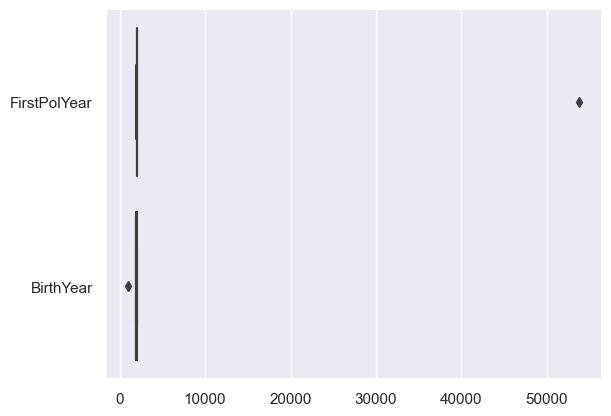

In [412]:
sns.boxplot(data=df[['FirstPolYear', 'BirthYear']], 
orient="h", 
palette="mako")
plt.show()

In [413]:
print('Outlier BirthYear', df['BirthYear'].min())
print('Outlier FirstPolYear', df['FirstPolYear'].max())

Outlier BirthYear 1028.0
Outlier FirstPolYear 53784.0


In [414]:
df = df[df['BirthYear'] != 1028]
df = df[df['FirstPolYear'] != 53784] #Removes the outlier value 

### BirthYear and FirstPolYear

In [415]:
print(f"People who were born after taking out insurance are {(((df[(df['FirstPolYear'] - df['BirthYear']) < 0].shape[0])/df.shape[0])*100):.2f}%")

People who were born after taking out insurance are 19.41%


In [416]:
print("Underage people who has insurance:", df[((2016 - df['BirthYear']) >= 15)&((2016 - df['BirthYear']) < 18)].shape[0])

Underage people who has insurance: 116


In [417]:
df = df.drop('BirthYear', axis=1)
numerical_col_list.remove('BirthYear')
print('Dataframe shape:', df.shape)

Dataframe shape: (10291, 12)


## Tratamento Outliers

### Univariate

In [418]:
def apply_limits_sup_inf(data, column, limits):
    
    def limit_apply(row, inf_limit, sup_limit):
        if row > sup_limit:
            return sup_limit
        elif row < inf_limit:
            return inf_limit
        else:
            return row

    if not limits:
        inf_lim = data[column].mean() - 3*data[column].std()
        sup_lim = data[column].mean() + 3*data[column].std()
    else:
        inf_lim = limits[0]
        sup_lim = limits[1]

    return data[column].apply(lambda row: limit_apply(row, inf_lim, sup_lim))

def plot_all_boxplots(df,metric_features):
	# All Numeric Variables' Box Plots in one figure
	sns.set()
	
	# Prepare figure. Create individual axes where each box plot will be placed
	fig, axes = plt.subplots(2, int(np.ceil(len(metric_features) / 2)), figsize=(20, 13))
	
	# Plot data
	# Iterate across axes objects and associate each box plot (hint: use the ax argument):
	for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
	    # CODE HERE
	    ax.boxplot(df[feat].dropna())
	    ax.set_title(feat,y=-.13)
	    
	# Layout
	# Add a centered title to the figure:
	title = 'Numeric Variables\' Box Plots' # notice the "\"
	fig.suptitle(title, fontsize=20)
	plt.show()

def plot_all_histograms(df,metric_features):
	# All Numeric Variables' Box Plots in one figure
	sns.set()
	
	# Prepare figure. Create individual axes where each box plot will be placed
	fig, axes = plt.subplots(2, int(np.ceil(len(metric_features) / 2)), figsize=(20, 13))
	
	# Plot data
	# Iterate across axes objects and associate each box plot (hint: use the ax argument):
	for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
	    # CODE HERE
	    ax.hist(df[feat].dropna())
	    ax.set_title(feat,y=-.13)
	    
	# Layout
	# Add a centered title to the figure:
	title = 'Numeric Variables\' Histograms' # notice the "\"
	fig.suptitle(title, fontsize=20)
	plt.show()

def plot_all_countplots(df,categorical_features):
    sns.set()
    # Prepare figure. Create individual axes where each box plot will be placed
    fig, axes = plt.subplots(2, int(np.ceil(len(categorical_features) / 2)), figsize=(20, 13))
    
    # Plot data
    # Iterate across axes objects and associate each box plot (hint: use the ax argument):
    for ax, feat in zip(axes.flatten(), categorical_features): # Notice the zip() function and flatten() method
        sns.countplot(x = df[feat],ax=ax,palette='Set2',order=df[feat].value_counts().index)
        ax.set_title(feat,y=-.13)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

        
    # Layout
    # Add a centered title to the figure:
    title = 'Categorical Variables\' Count Plots' # notice the "\"
    
    plt.show()

def return_tuple_max_min(data, column):
    return (data[column].min(), data[column].max())

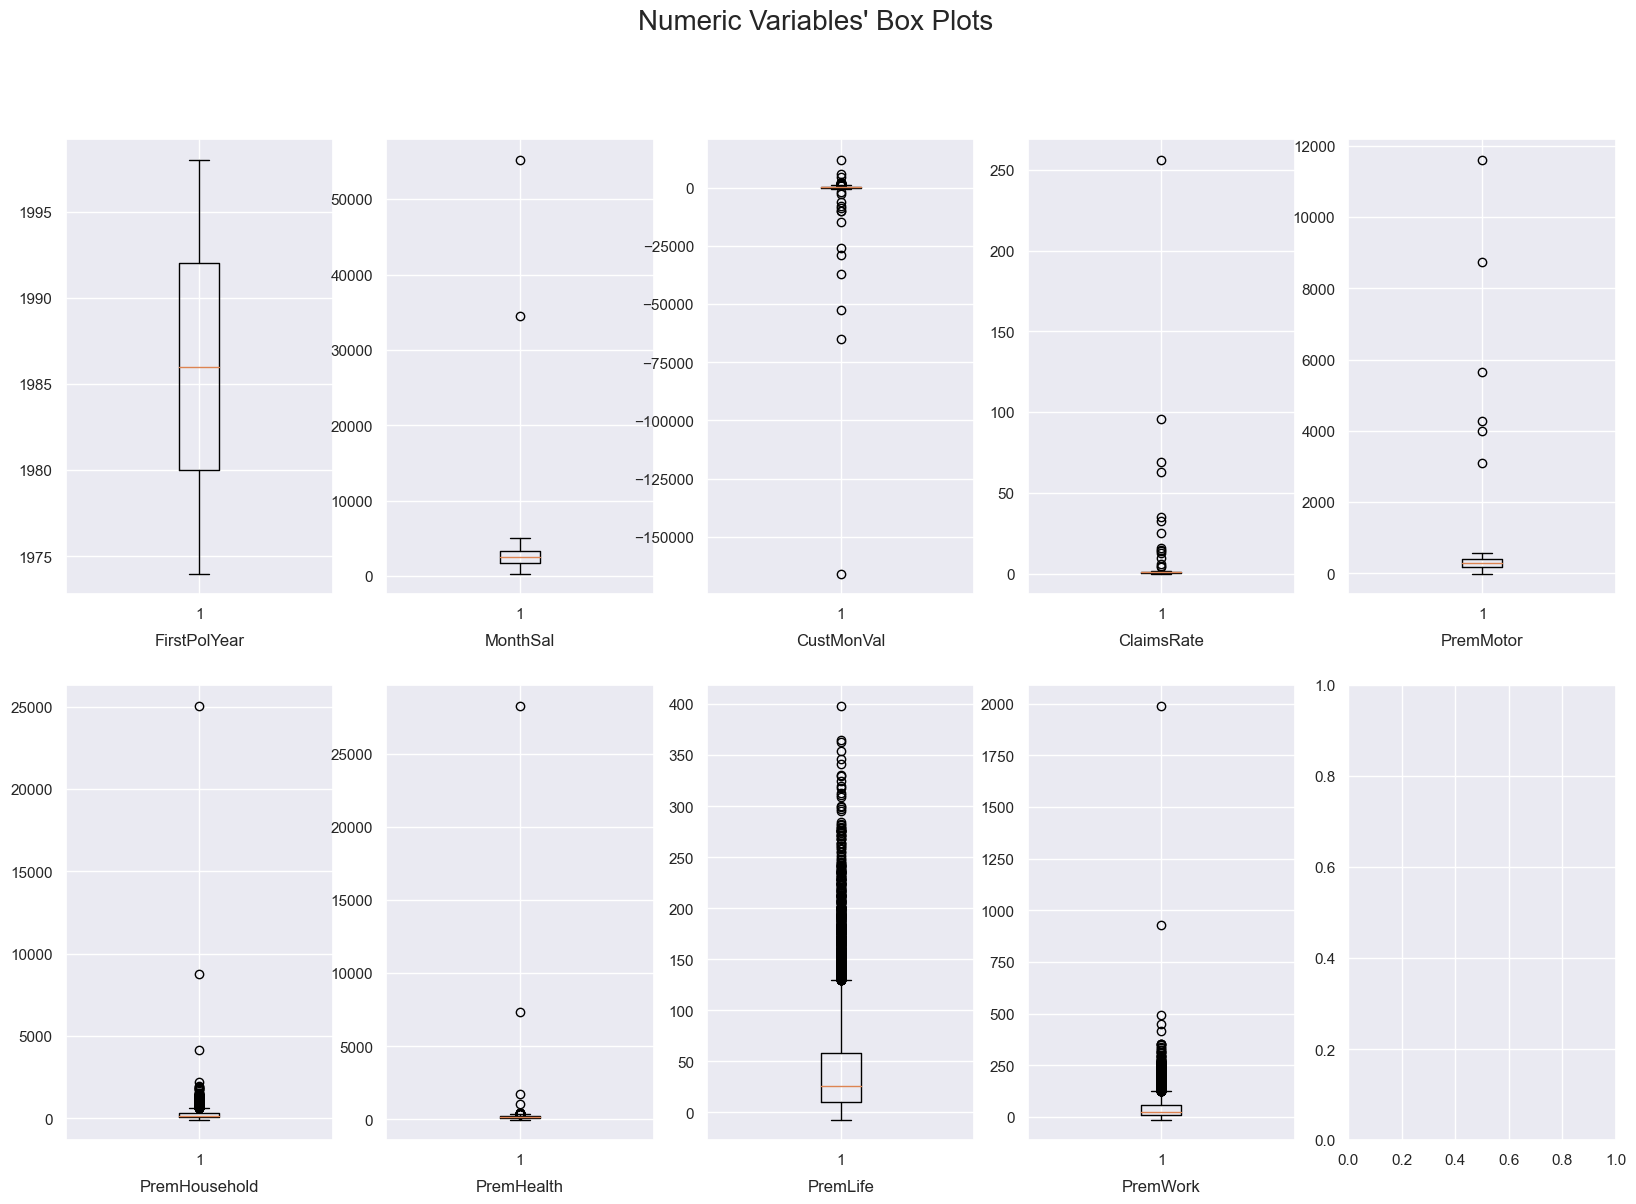

In [419]:
plot_all_boxplots(df, numerical_col_list)

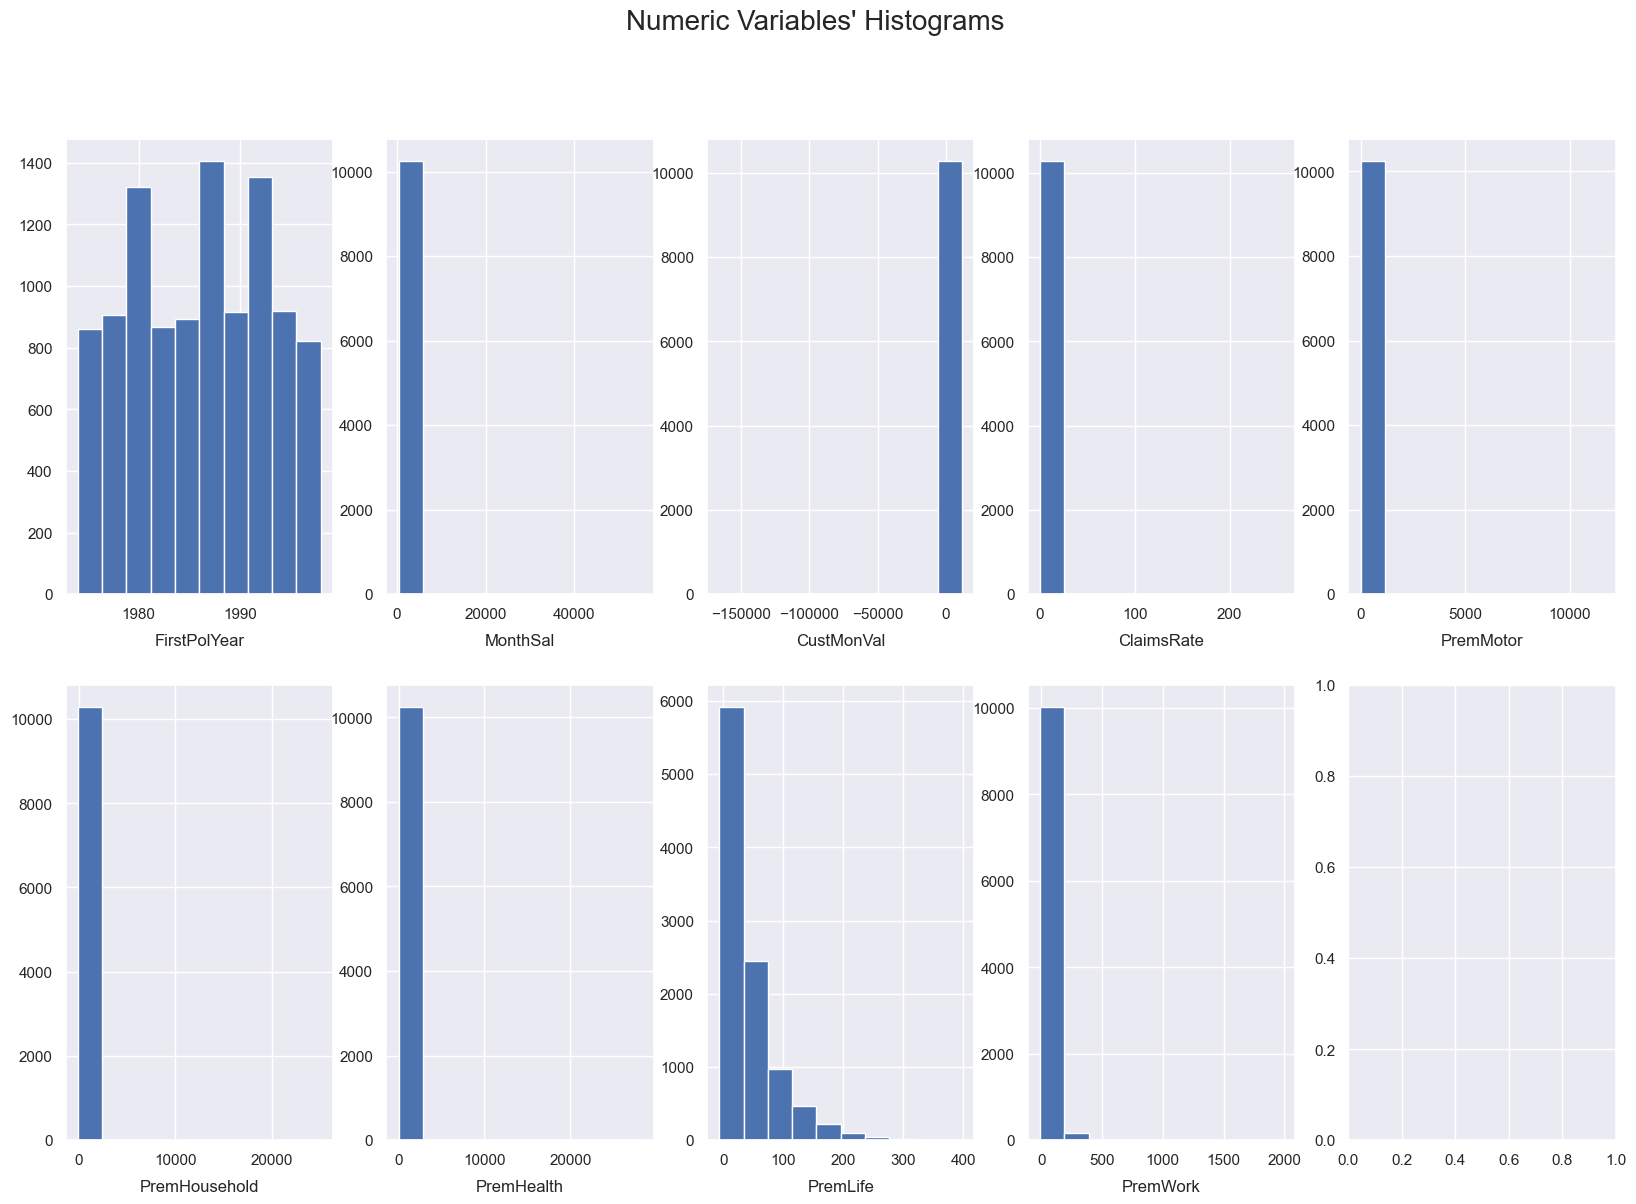

In [420]:
plot_all_histograms(df, numerical_col_list)

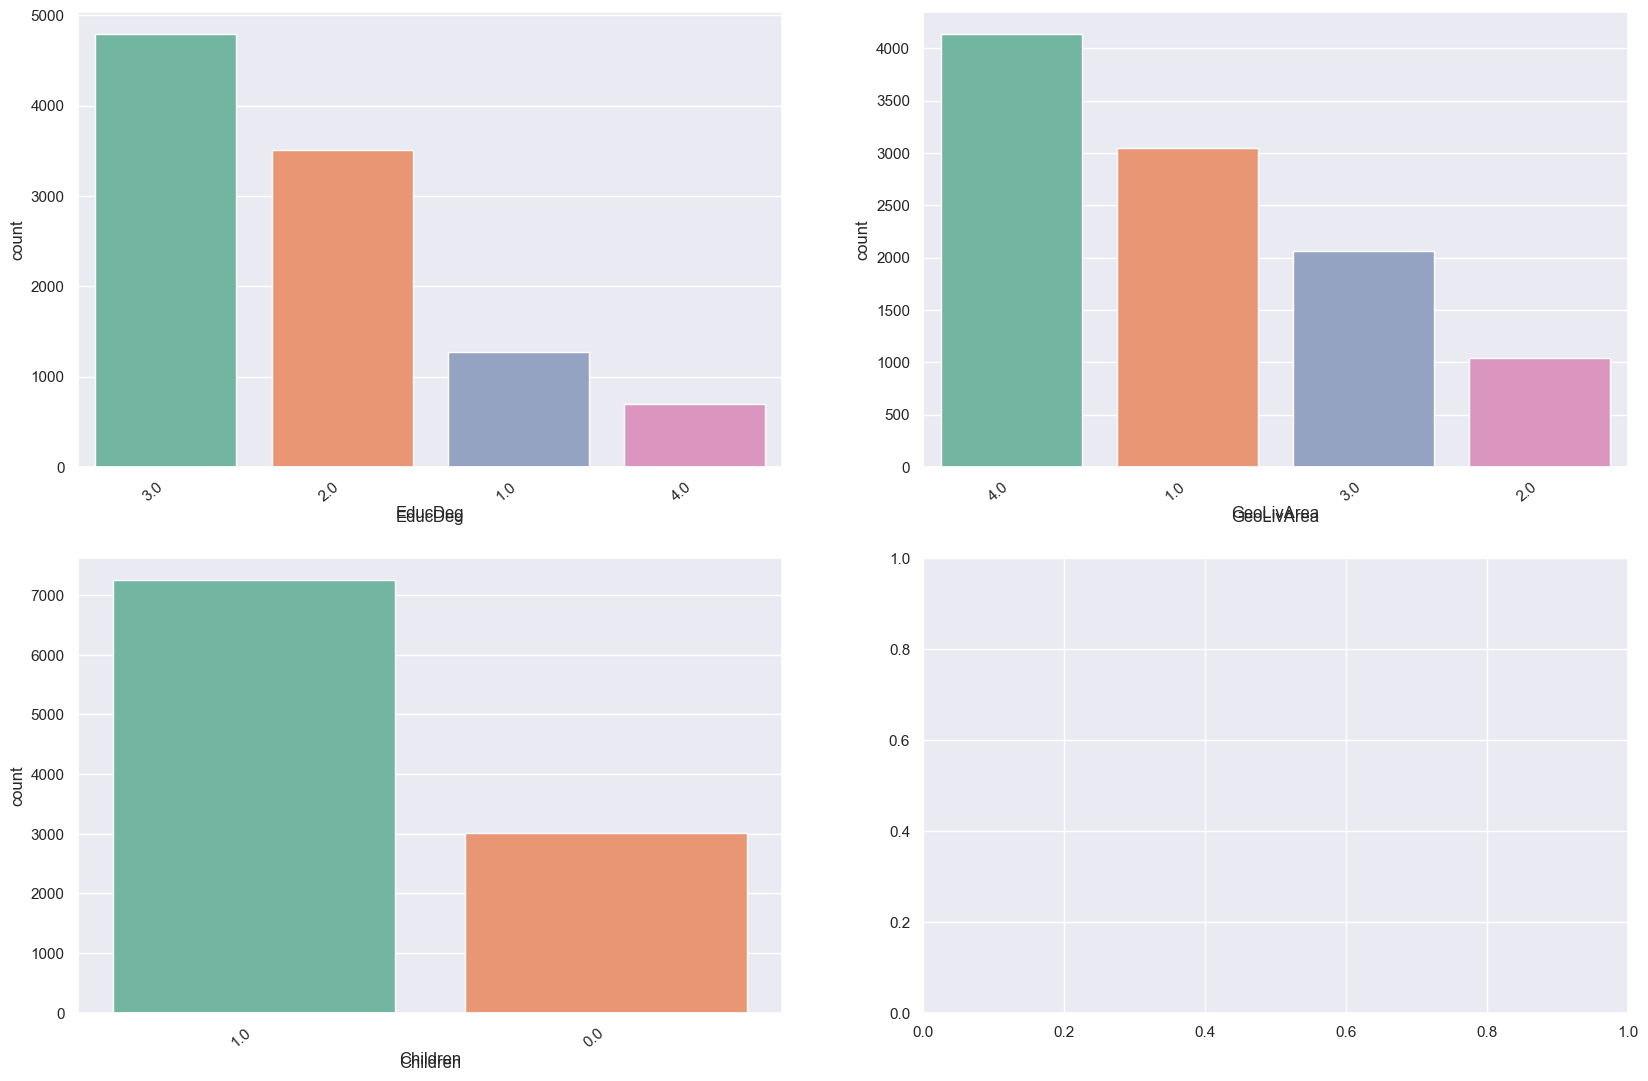

In [421]:
plot_all_countplots(df, categorical_col_list)

#### MonthSal

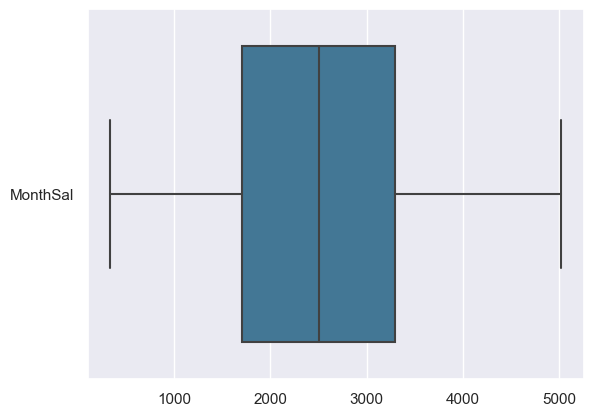

In [422]:
sns.boxplot(data=df[df['MonthSal'] < 10000][['MonthSal']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show()

In [423]:
df = df[df['MonthSal'] < 10000]

#### CustMonVal

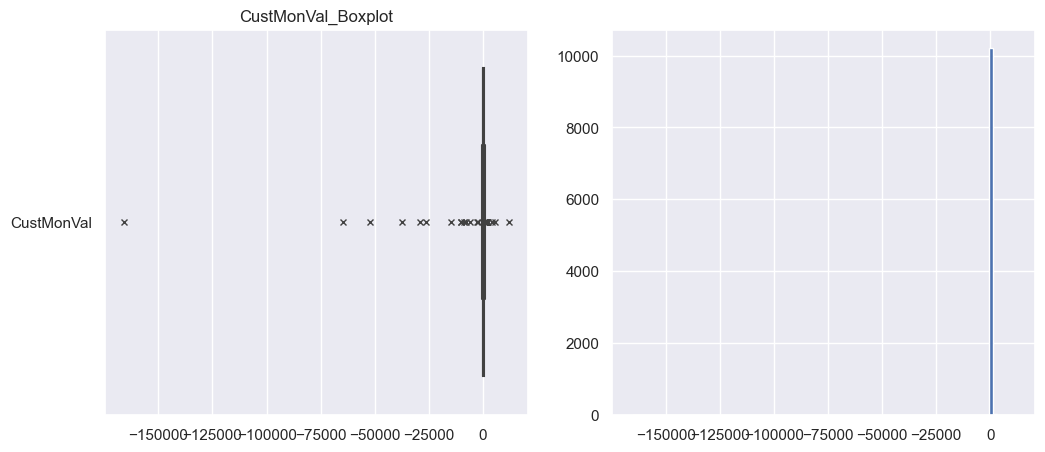

In [424]:
f,ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=df[['CustMonVal']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako",
ax=ax[0])
ax[0].set_title('CustMonVal_Boxplot')

df['CustMonVal'].hist(bins=100, figsize=(12,5), ax=ax[1])
plt.show() 

In [425]:
print("CustMonVal outliers: ", (df[~((-500<df['CustMonVal'])&(df['CustMonVal']<=1000))]).shape[0])
df_CustMonVal = df[((-500<=df['CustMonVal'])&(df['CustMonVal']<=1000))].copy()
CMV_limits = return_tuple_max_min(df_CustMonVal, 'CustMonVal')
df['CustMonVal'] = apply_limits_sup_inf(df, 'CustMonVal', CMV_limits)

CustMonVal outliers:  115


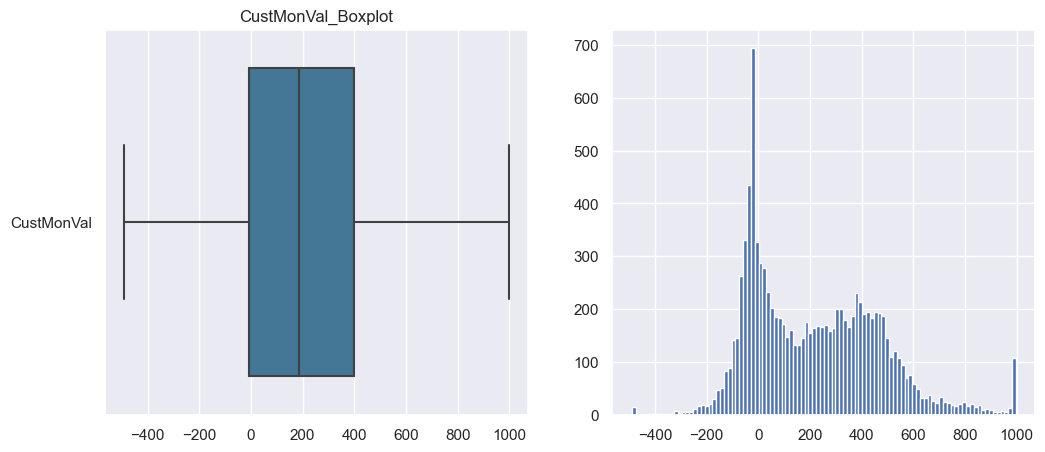

In [426]:
f,ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=df[['CustMonVal']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako",
ax=ax[0])
ax[0].set_title('CustMonVal_Boxplot')

df['CustMonVal'].hist(bins=100, figsize=(12,5), ax=ax[1])
plt.show() 

#### ClaimsRate

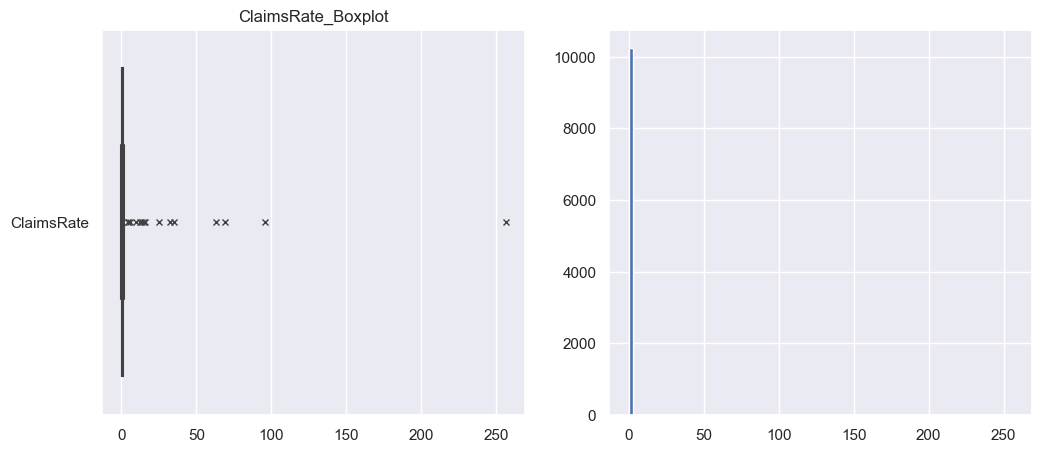

In [427]:

f,ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=df[['ClaimsRate']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako",
ax=ax[0])
ax[0].set_title('ClaimsRate_Boxplot')

df['ClaimsRate'].hist(bins=100, figsize=(12,5), ax=ax[1])
plt.show() 

In [428]:
print("ClaimsRate outliers ", df[df['ClaimsRate'] > 4].shape[0])
df_ClaimsRate = df[df['ClaimsRate'] < 4].copy()
ClaimsRate_limits = return_tuple_max_min(df_ClaimsRate, 'ClaimsRate')
df['ClaimsRate'] = apply_limits_sup_inf(df, 'ClaimsRate', ClaimsRate_limits)

ClaimsRate outliers  15


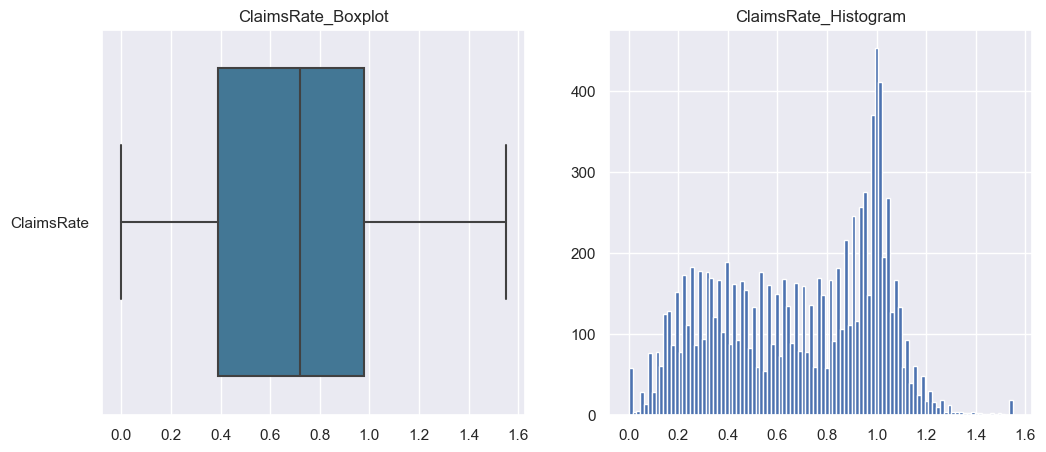

In [429]:
f,ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=df[['ClaimsRate']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako",
ax=ax[0])
ax[0].set_title('ClaimsRate_Boxplot')

df['ClaimsRate'].hist(bins=100, figsize=(12,5), ax=ax[1])
ax[1].set_title('ClaimsRate_Histogram')
plt.show() 

#### PremMotor

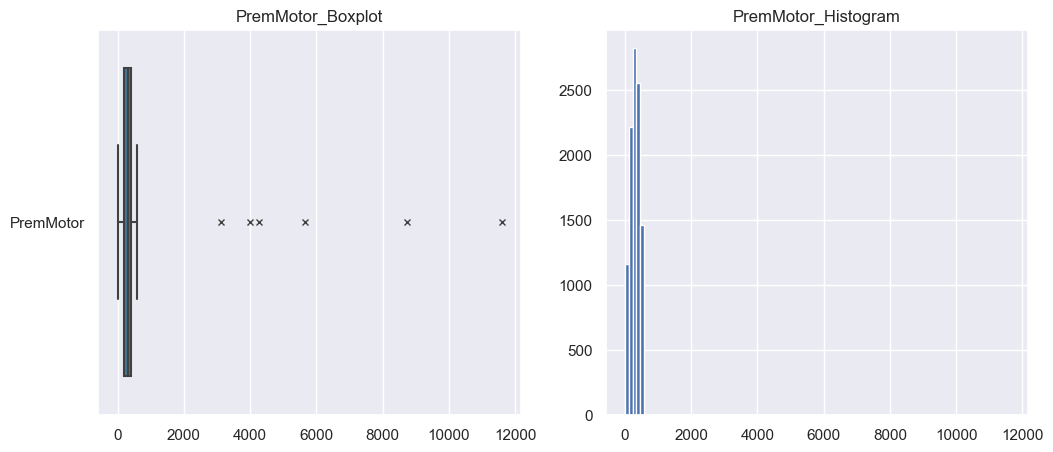

In [430]:

f,ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=df[['PremMotor']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako",
ax=ax[0])
ax[0].set_title('PremMotor_Boxplot')

df['PremMotor'].hist(bins=100, figsize=(12,5), ax=ax[1])
ax[1].set_title('PremMotor_Histogram')
plt.show() 

In [431]:
print("PremMotor outliers ", df[df['PremMotor'] > 2000].shape[0])
df_PremMotor = df[df['PremMotor'] < 2000].copy()
PremMotor_limits = return_tuple_max_min(df_PremMotor, 'PremMotor')
df['PremMotor'] = apply_limits_sup_inf(df, 'PremMotor', PremMotor_limits)

PremMotor outliers  6


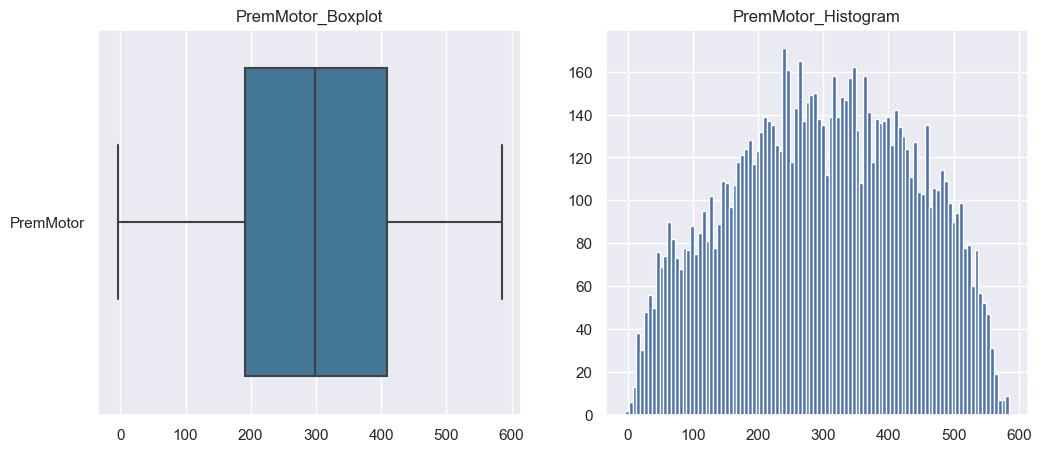

In [432]:

f,ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=df[['PremMotor']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako",
ax=ax[0])
ax[0].set_title('PremMotor_Boxplot')

df['PremMotor'].hist(bins=100, figsize=(12,5), ax=ax[1])
ax[1].set_title('PremMotor_Histogram')
plt.show() 

#### PremHousehold

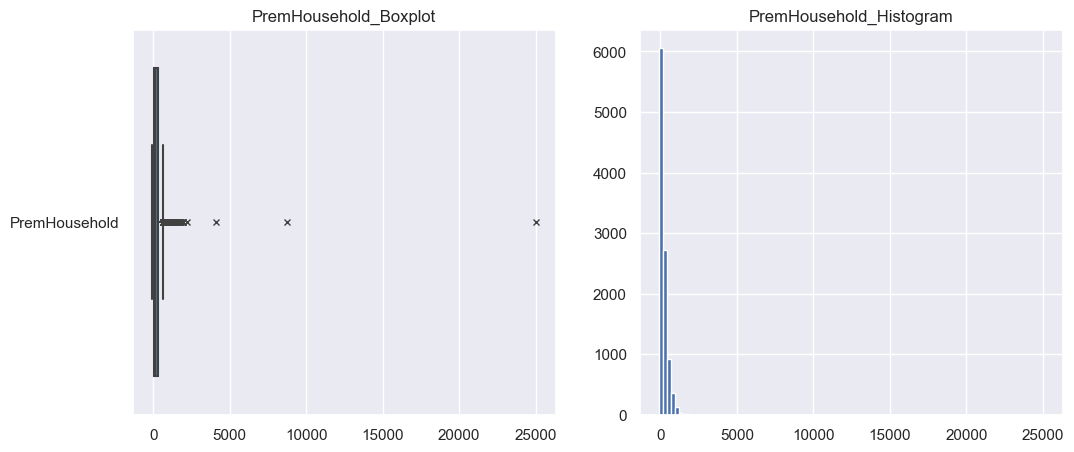

In [433]:
f,ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=df[['PremHousehold']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako",
ax=ax[0])
ax[0].set_title('PremHousehold_Boxplot')

df['PremHousehold'].hist(bins=100, figsize=(12,5), ax=ax[1])
ax[1].set_title('PremHousehold_Histogram')
plt.show() 

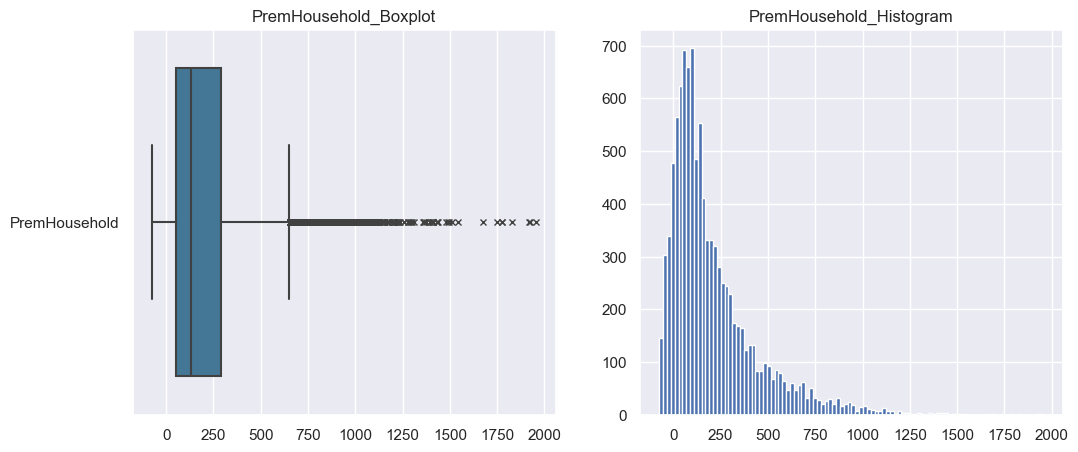

In [434]:
#Checking distribution with upper limit on 2000

f,ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=df[df['PremHousehold'] < 2000][['PremHousehold']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako",
ax=ax[0])
ax[0].set_title('PremHousehold_Boxplot')

df[df['PremHousehold'] < 2000]['PremHousehold'].hist(bins=100, figsize=(12,5), ax=ax[1])
ax[1].set_title('PremHousehold_Histogram')
plt.show() 

In [435]:
#Deciding to keep upper limit on 1250

print("PremHousehold outliers ", df[df['PremHousehold'] > 1250].shape[0])
df_PremHousehold = df[df['PremHousehold'] < 1250]
PremHousehold_limits = return_tuple_max_min(df_PremHousehold, 'PremHousehold')
df['PremHousehold'] = apply_limits_sup_inf(df, 'PremHousehold', PremHousehold_limits)

PremHousehold outliers  37


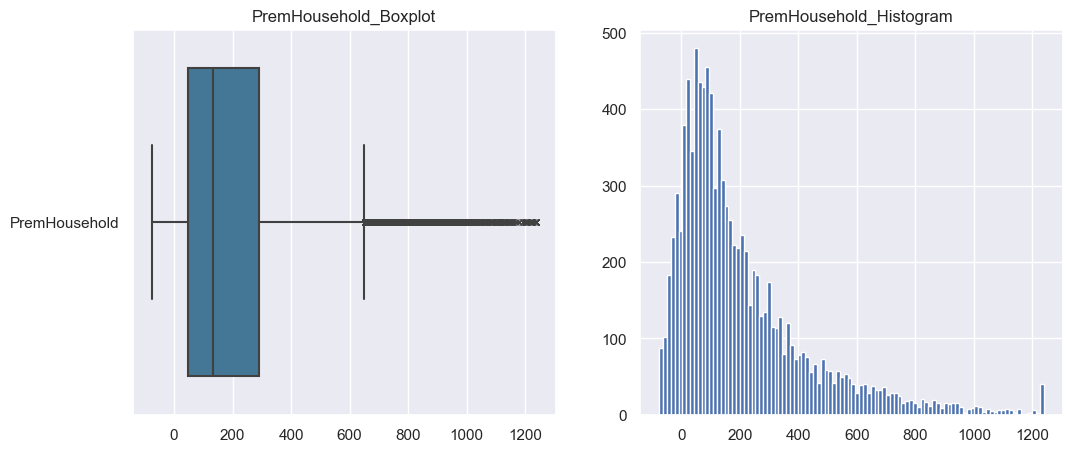

In [436]:
f,ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=df[['PremHousehold']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako",
ax=ax[0])
ax[0].set_title('PremHousehold_Boxplot')

df['PremHousehold'].hist(bins=100, figsize=(12,5), ax=ax[1])
ax[1].set_title('PremHousehold_Histogram')
plt.show() 

#### PremHealth

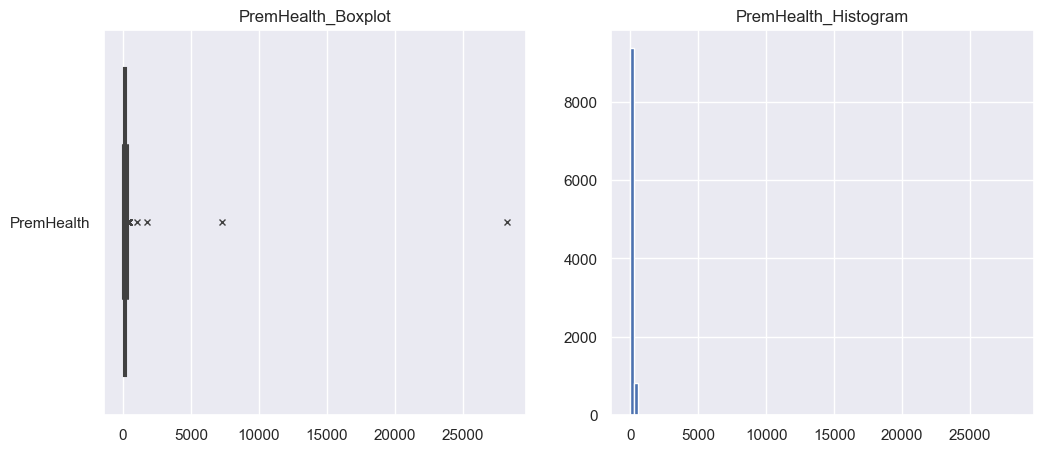

In [437]:
f,ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=df[['PremHealth']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako",
ax=ax[0])
ax[0].set_title('PremHealth_Boxplot')

df['PremHealth'].hist(bins=100, figsize=(12,5), ax=ax[1])
ax[1].set_title('PremHealth_Histogram')
plt.show() 

In [438]:
print("PremHealth outliers ", df[df['PremHealth'] > 400].shape[0])
df_PremHealth = df[df['PremHealth'] < 400]
PremHealth_limits = return_tuple_max_min(df_PremHealth, 'PremHealth')
df['PremHealth'] = apply_limits_sup_inf(df, 'PremHealth', PremHealth_limits)

PremHealth outliers  11


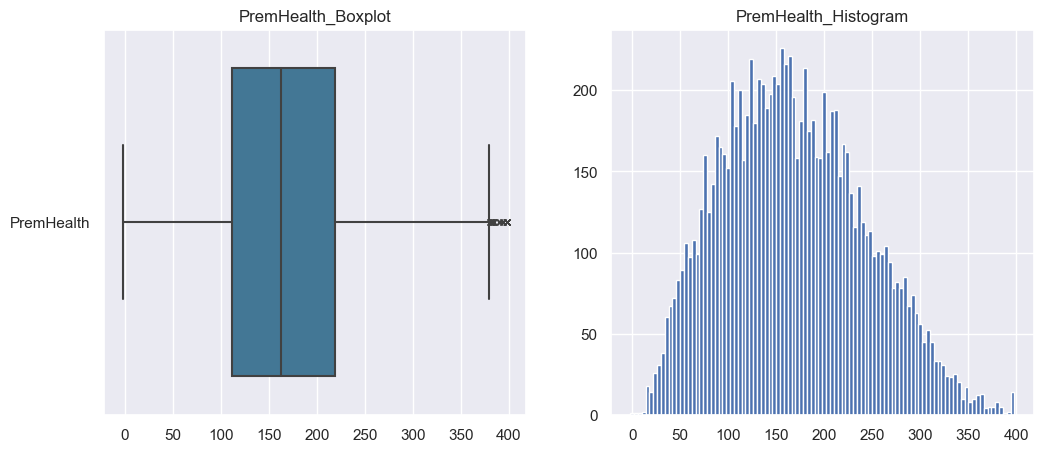

In [439]:
f,ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=df[['PremHealth']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako",
ax=ax[0])
ax[0].set_title('PremHealth_Boxplot')

df['PremHealth'].hist(bins=100, figsize=(12,5), ax=ax[1])
ax[1].set_title('PremHealth_Histogram')
plt.show() 

#### PremLife

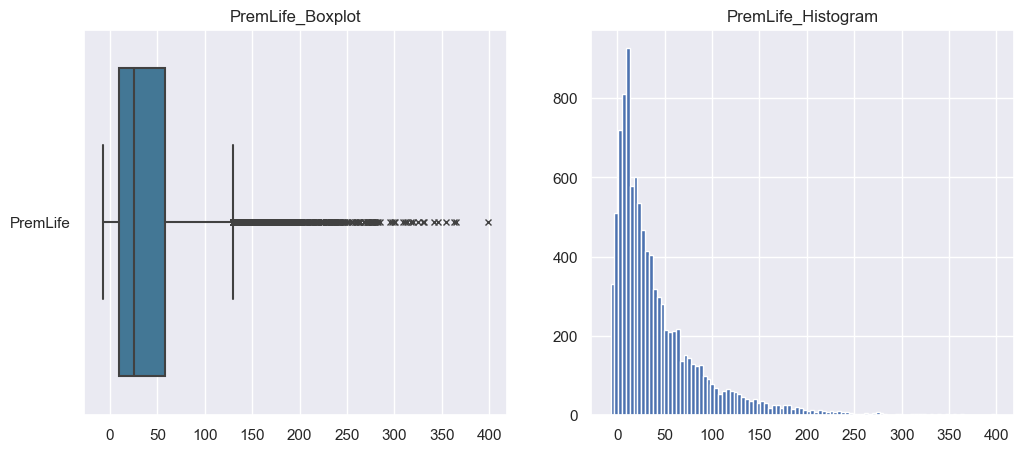

In [440]:
f,ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=df[['PremLife']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako",
ax=ax[0])
ax[0].set_title('PremLife_Boxplot')

df['PremLife'].hist(bins=100, figsize=(12,5), ax=ax[1])
ax[1].set_title('PremLife_Histogram')
plt.show() 

In [441]:
print("PremLife outliers ", df[df['PremLife'] > 250].shape[0])
df_PremLife = df[df['PremLife'] < 250]
PremLife_limits = return_tuple_max_min(df_PremLife, 'PremLife')
df['PremLife'] = apply_limits_sup_inf(df, 'PremLife', PremLife_limits)

PremLife outliers  50


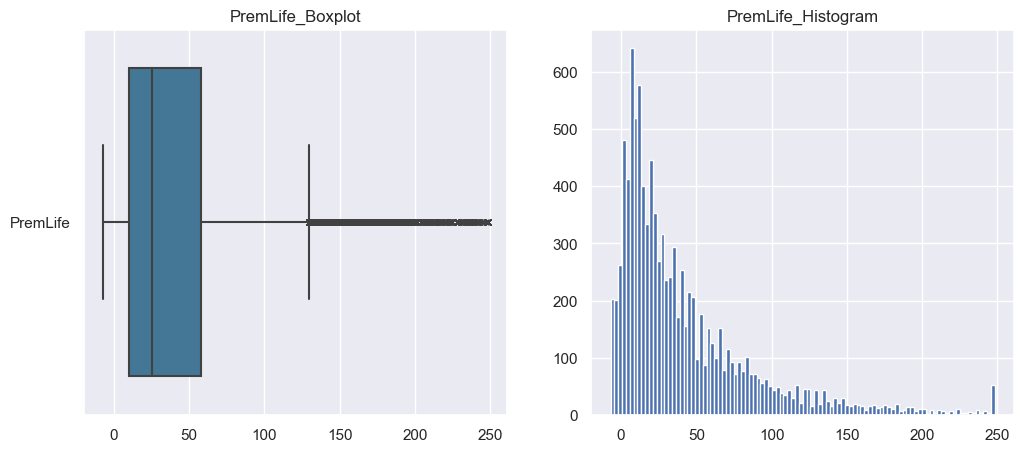

In [442]:
f,ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=df[['PremLife']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako",
ax=ax[0])
ax[0].set_title('PremLife_Boxplot')

df['PremLife'].hist(bins=100, figsize=(12,5), ax=ax[1])
ax[1].set_title('PremLife_Histogram')
plt.show() 

#### PremWork

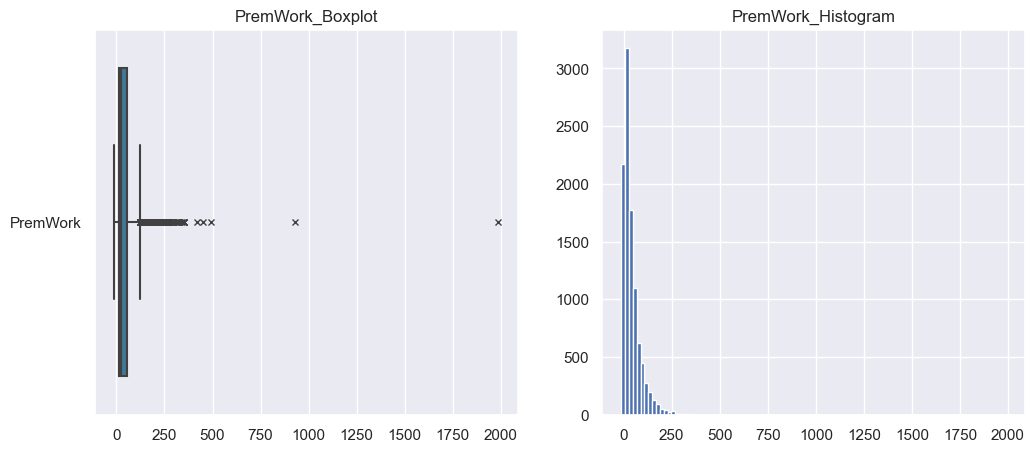

In [443]:
f,ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=df[['PremWork']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako",
ax=ax[0])
ax[0].set_title('PremWork_Boxplot')

df['PremWork'].hist(bins=100, figsize=(12,5), ax=ax[1])
ax[1].set_title('PremWork_Histogram')
plt.show() 

In [444]:
print("PremWork outliers ", df[df['PremWork'] > 250].shape[0])
df_PremWork = df[df['PremWork'] < 250]
PremWork_limits = return_tuple_max_min(df_PremWork, 'PremWork')
df['PremWork'] = apply_limits_sup_inf(df, 'PremWork', PremWork_limits)

PremWork outliers  55


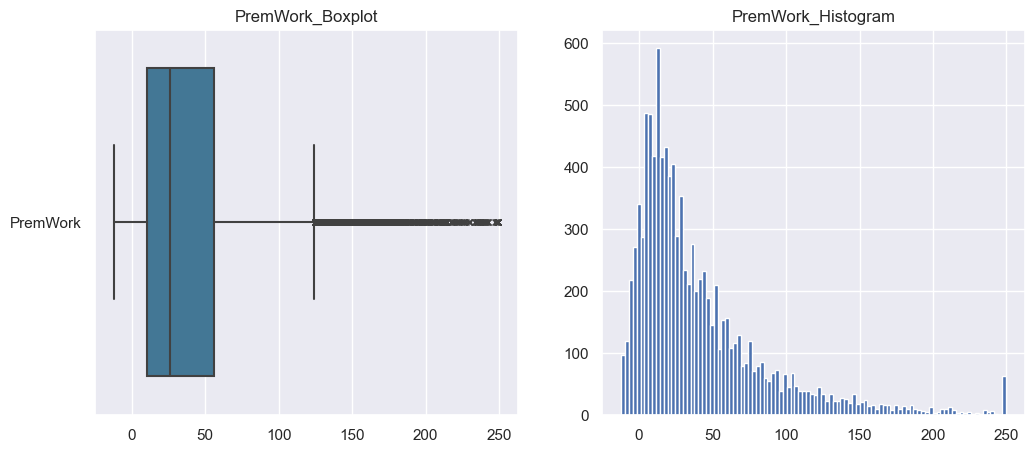

In [445]:
f,ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=df[['PremWork']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako",
ax=ax[0])
ax[0].set_title('PremWork_Boxplot')

df['PremWork'].hist(bins=100, figsize=(12,5), ax=ax[1])
ax[1].set_title('PremWork_Histogram')
plt.show() 

### Missing Values

In [446]:
df_treat_nan = df.copy()
print("Dataset shape before dropping NaNs ", df_treat_nan.shape)

Dataset shape before dropping NaNs  (10253, 12)


#### Numerical

In [447]:
nans_index = df_treat_nan.isna().any(axis=1)
df_treat_nan[numerical_col_list][nans_index].head()

,FirstPolYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,
69,1983.0,1399.0,476.65,0.33,330.73,186.70,211.15,NaN,15.78
139,1979.0,2538.0,149.59,0.69,194.26,305.60,NaN,37.34,17.67
185,1993.0,2419.0,-62.23,1.07,NaN,253.95,230.60,5.89,43.12
195,1990.0,2349.0,-101.00,1.14,469.31,-65.00,115.80,NaN,11.00
297,NaN,3591.0,-49.11,1.04,447.64,-25.00,130.58,0.89,12.89


In [448]:
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_treat_nan[numerical_col_list] = imputer.fit_transform(df_treat_nan[numerical_col_list])
df_treat_nan.loc[nans_index, numerical_col_list].head()

,FirstPolYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,
69,1983.0,1399.0,476.65,0.33,330.73,186.70,211.150,33.784,15.78
139,1979.0,2538.0,149.59,0.69,194.26,305.60,226.598,37.340,17.67
185,1993.0,2419.0,-62.23,1.07,251.87,253.95,230.600,5.890,43.12
195,1990.0,2349.0,-101.00,1.14,469.31,-65.00,115.800,11.024,11.00
297,1981.8,3591.0,-49.11,1.04,447.64,-25.00,130.580,0.890,12.89


#### Categorical

In [449]:
modes = df_treat_nan[categorical_col_list].mode().loc[0]
modes

EducDeg       3.0
GeoLivArea    4.0
Children      1.0
Name: 0, dtype: float64

In [450]:
df_treat_nan.fillna(modes, inplace=True)
df_treat_nan.isna().sum()

FirstPolYear     0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

#### Fix columns type

In [451]:
convert_dict = {'FirstPolYear': int,
                #'BirthYear': int,
                'EducDeg': int,
                'GeoLivArea': int,
                'Children': int}
 
df_treat_nan = df_treat_nan.astype(convert_dict) 

print("Dataset shape after dropping NaNs ", df_treat_nan.shape)

Dataset shape after dropping NaNs  (10253, 12)


### Multivariate

In [452]:
#Find multivariate outliers with DBSCAN

df_to_dbscan = df_treat_nan[numerical_col_list].copy()
#Scale the data
scaler = StandardScaler()
df_to_dbscan[numerical_col_list] = scaler.fit_transform(df_to_dbscan[numerical_col_list])
#Fit DBSCAN
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df_to_dbscan)
#Add the labels to the dataframe
df_to_dbscan['dbscan_labels'] = dbscan_labels
#Count the number of outliers
Counter(dbscan_labels)





Counter({0: 10060, -1: 193})

In [453]:
#Drop the outliers
outliers_idx = df_to_dbscan[df_to_dbscan['dbscan_labels'] == -1].index
df_wo_out = df_treat_nan.drop(outliers_idx).copy()

print("Number of outliers: {}\n Original dataset shape : {}\n Without outlier dataset shape: {} ".format(
   len(outliers_idx),
    df_treat_nan.shape,
    df_wo_out.shape))

Number of outliers: 193
 Original dataset shape : (10253, 12)
 Without outlier dataset shape: (10060, 12) 


# Feature Engeneering

## Feature Creation

In [454]:
df_wo_out.head()

,FirstPolYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,
1,1985,2,2177.0,1,1,380.97,0.39,375.85,79.45,146.36,47.01,16.89
2,1981,2,677.0,4,1,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
3,1991,1,2277.0,3,0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
4,1990,3,1099.0,4,1,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
5,1986,3,1763.0,4,1,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [455]:
#Feature engineering

#Create a new feature: Total premium
df_wo_out['TotalPrem'] = df_wo_out['PremWork'] + df_wo_out['PremLife'] + df_wo_out['PremHealth'] + df_wo_out['PremMotor'] + df_wo_out['PremHousehold']
#Create a new feature: Ratios of premium
df_wo_out['WorkPrem_ratio'] = df_wo_out['PremWork'] / df_wo_out['TotalPrem']
df_wo_out['LifePrem_ratio'] = df_wo_out['PremLife'] / df_wo_out['TotalPrem']
df_wo_out['HealthPrem_ratio'] = df_wo_out['PremHealth'] / df_wo_out['TotalPrem']
df_wo_out['MotorPrem_ratio'] = df_wo_out['PremMotor'] / df_wo_out['TotalPrem']
df_wo_out['HouseholdPrem_ratio'] = df_wo_out['PremHousehold'] / df_wo_out['TotalPrem']
#Create a new feature: Risk budget
df_wo_out['RiskBudget'] = df_wo_out['TotalPrem'] /  (df_wo_out['MonthSal']*12) 
#Create a new feature: Cancelation
df_wo_out['has_cancelled'] = df_wo_out[['PremWork', 'PremLife', 'PremHealth', 'PremMotor', 'PremHousehold']].apply(lambda x: 1 if x.min() < 0 else 0, axis=1)
#Update the list of numerical and ordinal columns
numerical_col_list = numerical_col_list + ['TotalPrem', 'WorkPrem_ratio', 'LifePrem_ratio', 'HealthPrem_ratio', 'MotorPrem_ratio', 'HouseholdPrem_ratio', 'RiskBudget']
ordinal_col_list.append('has_cancelled')
categorical_col_list.append('has_cancelled')


print("Numerical columns: ", numerical_col_list)
print("Ordinal columns: ", ordinal_col_list)
print("Categorical columns: ", categorical_col_list)
print("Dataset shape after feature engineering ", df_wo_out.shape)

Numerical columns:  ['FirstPolYear', 'MonthSal', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork', 'TotalPrem', 'WorkPrem_ratio', 'LifePrem_ratio', 'HealthPrem_ratio', 'MotorPrem_ratio', 'HouseholdPrem_ratio', 'RiskBudget']
Ordinal columns:  ['EducDeg', 'has_cancelled']
Categorical columns:  ['EducDeg', 'GeoLivArea', 'Children', 'has_cancelled']
Dataset shape after feature engineering  (10060, 20)


## Feature Selection

In [456]:
def plot_correlation_heatmap(df,metric_features,corr_method = 'pearson'):
    #Correlation heatmap
    corr = df[metric_features].corr(method=corr_method)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot= True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()


In [457]:
df_wo_out.head()

,FirstPolYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,TotalPrem,WorkPrem_ratio,LifePrem_ratio,HealthPrem_ratio,MotorPrem_ratio,HouseholdPrem_ratio,RiskBudget,has_cancelled
CustID,,,,,,,,,,,,,,,,,,,,
1,1985,2,2177.0,1,1,380.97,0.39,375.85,79.45,146.36,47.01,16.89,665.56,0.025377,0.070632,0.219905,0.564712,0.119373,0.025477,0
2,1981,2,677.0,4,1,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,910.96,0.116503,0.213489,0.128096,0.085031,0.456881,0.112132,0
3,1991,1,2277.0,3,0,504.67,0.28,206.15,224.50,124.58,86.35,99.02,740.60,0.133702,0.116595,0.168215,0.278355,0.303133,0.027104,0
4,1990,3,1099.0,4,1,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,600.68,0.047180,0.058833,0.518030,0.303789,0.072168,0.045547,0
5,1986,3,1763.0,4,1,35.23,0.90,338.62,47.80,182.59,18.78,41.45,629.24,0.065873,0.029846,0.290175,0.538141,0.075965,0.029743,0


### Correlation

/var/folders/w0/rtcy3mbs6h38d0yjvjcd8yshb3_7pc/T/ipykernel_2376/63559323.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


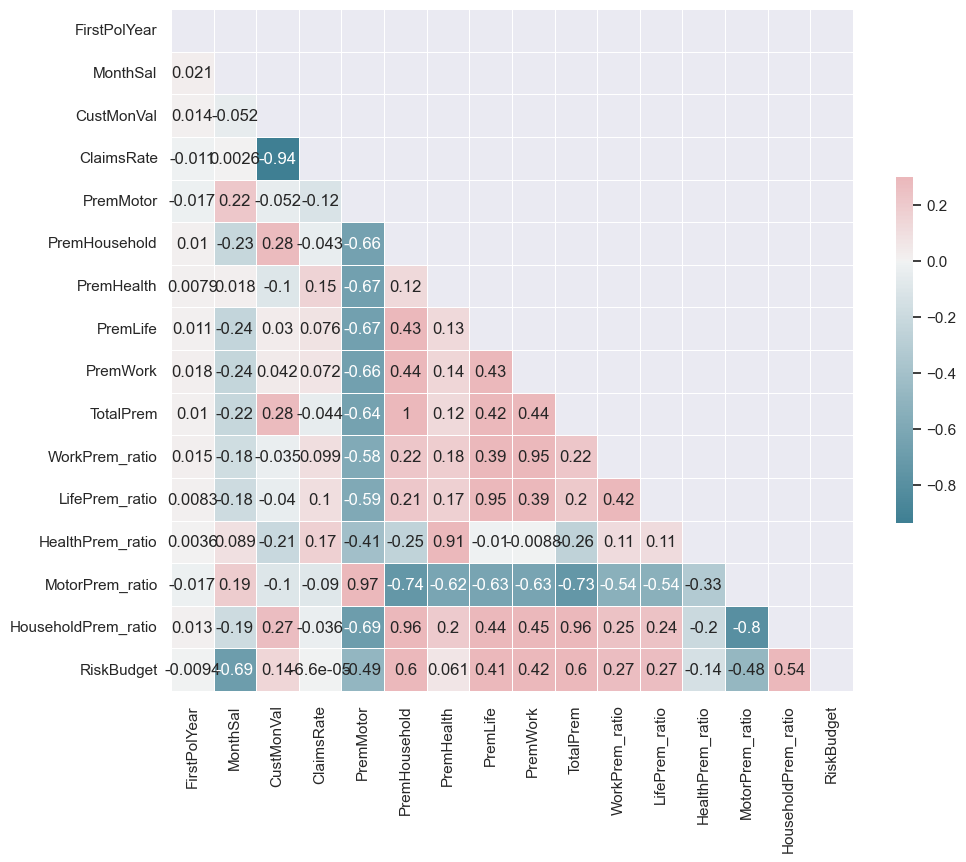

In [458]:
plot_correlation_heatmap(df_wo_out, numerical_col_list)

In [459]:
# Create a function to return for each column, the number of columns that have a correlation higher than a threshold and the list of these columns. Disconsider the correlation with the column itself.
def get_high_correlated_columns(df, threshold, col_list):
    corr = df[col_list].corr(method='pearson')
    corr = corr.abs().unstack()
    corr = corr.sort_values(ascending=False)
    corr = corr[corr >= threshold]
    corr = corr[corr < 1]
    corr = pd.DataFrame(corr).reset_index()
    corr.columns = ['col1', 'col2', 'corr']
    corr = corr.groupby('col1')['col2'].agg(['count', 'unique']).reset_index()
    return corr.sort_values('count', ascending=False)

In [460]:
get_high_correlated_columns(df_wo_out, 0.8, numerical_col_list)

,col1,count,unique
3,HouseholdPrem_ratio,3,"[PremHousehold, TotalPrem, MotorPrem_ratio]"
5,MotorPrem_ratio,2,"[PremMotor, HouseholdPrem_ratio]"
7,PremHousehold,2,"[TotalPrem, HouseholdPrem_ratio]"
11,TotalPrem,2,"[PremHousehold, HouseholdPrem_ratio]"
0,ClaimsRate,1,[CustMonVal]
1,CustMonVal,1,[ClaimsRate]
2,HealthPrem_ratio,1,[PremHealth]
4,LifePrem_ratio,1,[PremLife]
6,PremHealth,1,[HealthPrem_ratio]
8,PremLife,1,[LifePrem_ratio]


In [461]:
# Looks like that some premium columns are correlated with each other. We can combine them into a single column (based on their total amount).
df_wo_out_clean = df_wo_out.copy()
#Create a new feature: Household + Motor ratio
df_wo_out_clean['HouseholdMotor_ratio'] = (df_wo_out_clean['PremHousehold'] + df_wo_out_clean['PremMotor']) / df_wo_out_clean['TotalPrem']
df_wo_out_clean = df_wo_out_clean.drop(['HouseholdPrem_ratio', 'MotorPrem_ratio'], axis=1)

# Also, the premium ratio columns are all higly correlated with their respective total premium columns. We can drop the total premium columns.
df_wo_out_clean = df_wo_out_clean.drop(['PremWork', 'PremLife', 'PremHealth', 'PremMotor', 'PremHousehold'], axis=1)

#The  CustMonVal and ClaimsRate are both very correlated. We can drop the CustMonVal column since its more correlated with other features.
df_wo_out_clean = df_wo_out_clean.drop(['CustMonVal'], axis=1)

#Update the list of numerical and ordinal columns
numerical_col_list = numerical_col_list + ['HouseholdMotor_ratio']
numerical_col_list = [col for col in numerical_col_list if col not in [
    'HouseholdPrem_ratio','MotorPrem_ratio',
    'PremWork', 'PremLife',
    'PremHealth', 'PremMotor',
    'PremHousehold','CustMonVal']]
print("Numerical columns: ", numerical_col_list)
print("Ordinal columns: ", ordinal_col_list)
print("Categorical columns: ", categorical_col_list)
print("Final dataset shape", df_wo_out_clean.shape)

Numerical columns:  ['FirstPolYear', 'MonthSal', 'ClaimsRate', 'TotalPrem', 'WorkPrem_ratio', 'LifePrem_ratio', 'HealthPrem_ratio', 'RiskBudget', 'HouseholdMotor_ratio']
Ordinal columns:  ['EducDeg', 'has_cancelled']
Categorical columns:  ['EducDeg', 'GeoLivArea', 'Children', 'has_cancelled']
Final dataset shape (10060, 13)


In [462]:
df_wo_out_clean.head()

,FirstPolYear,EducDeg,MonthSal,GeoLivArea,Children,ClaimsRate,TotalPrem,WorkPrem_ratio,LifePrem_ratio,HealthPrem_ratio,RiskBudget,has_cancelled,HouseholdMotor_ratio
CustID,,,,,,,,,,,,,
1,1985,2,2177.0,1,1,0.39,665.56,0.025377,0.070632,0.219905,0.025477,0,0.684086
2,1981,2,677.0,4,1,1.12,910.96,0.116503,0.213489,0.128096,0.112132,0,0.541912
3,1991,1,2277.0,3,0,0.28,740.60,0.133702,0.116595,0.168215,0.027104,0,0.581488
4,1990,3,1099.0,4,1,0.99,600.68,0.047180,0.058833,0.518030,0.045547,0,0.375957
5,1986,3,1763.0,4,1,0.90,629.24,0.065873,0.029846,0.290175,0.029743,0,0.614106


/var/folders/w0/rtcy3mbs6h38d0yjvjcd8yshb3_7pc/T/ipykernel_2376/63559323.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


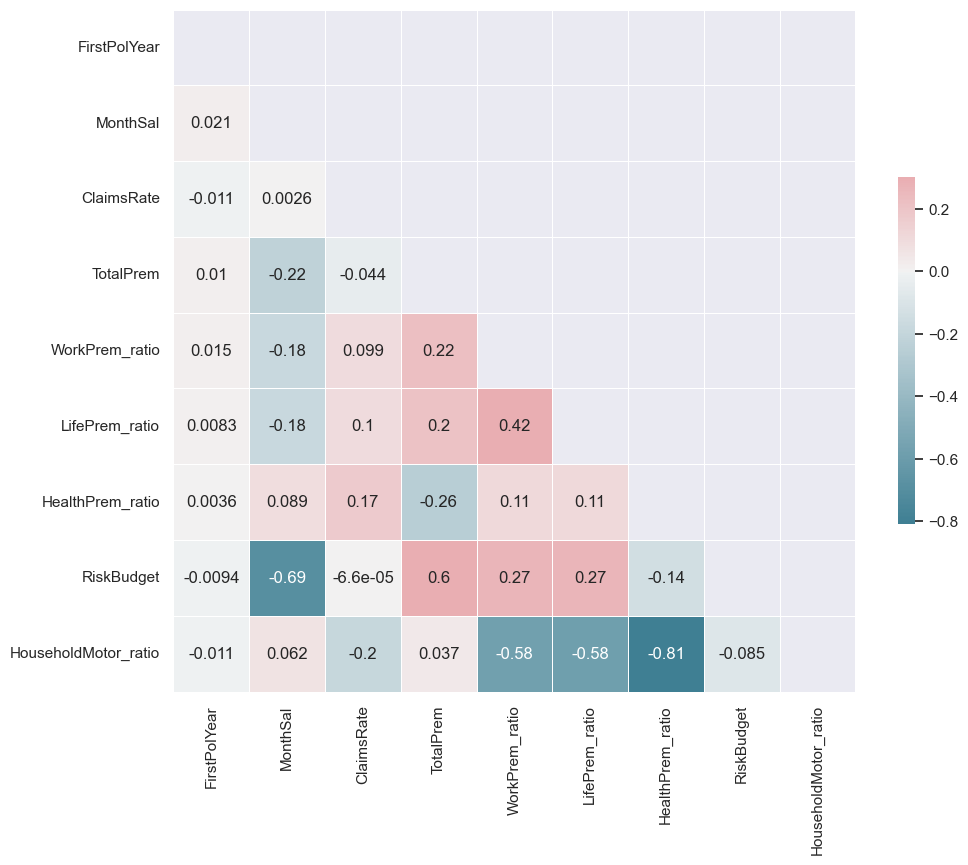

In [463]:
plot_correlation_heatmap(df_wo_out_clean, numerical_col_list)

### Categorical selection

### Area

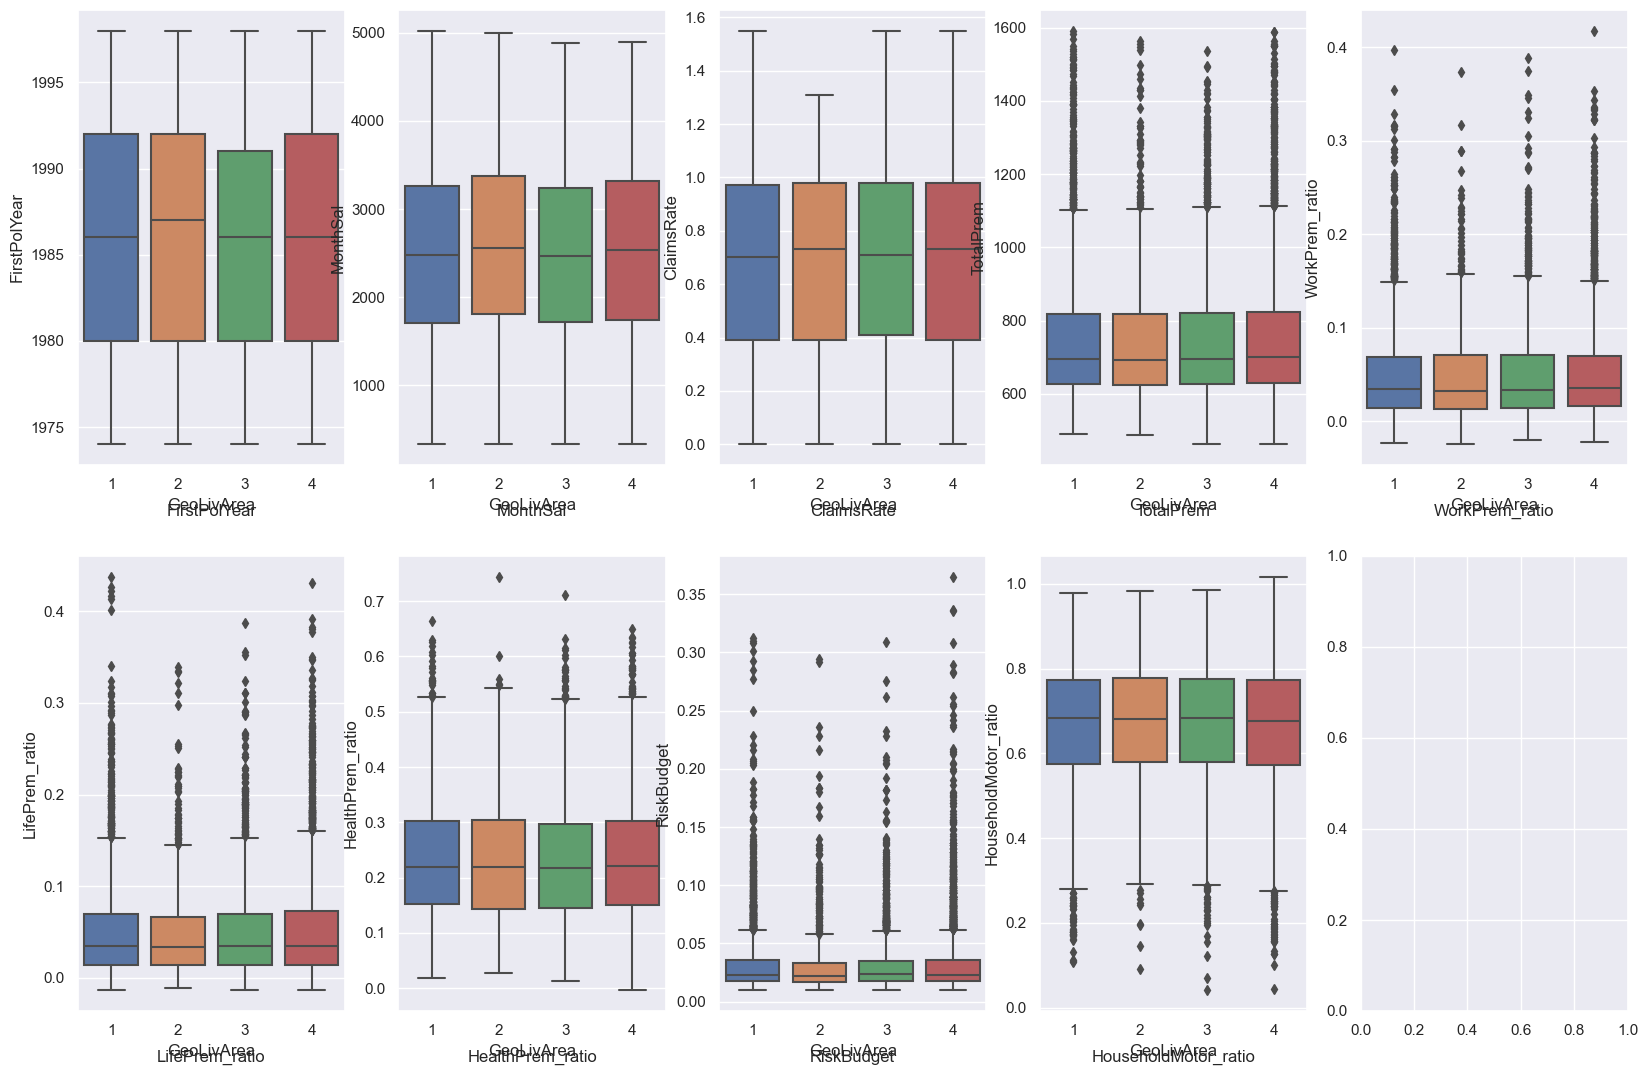

In [481]:
fig, axes = plt.subplots(2, int(np.ceil(len(numerical_col_list) / 2)), figsize=(20, 13))
	
# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), numerical_col_list): # Notice the zip() function and flatten() method
    # CODE HERE
    sns.boxplot(
        x = df_wo_out_clean['GeoLivArea'],
        y = df_wo_out_clean[feat],
        ax = ax)
    ax.set_title(feat,y=-.13)
	    

#### Children

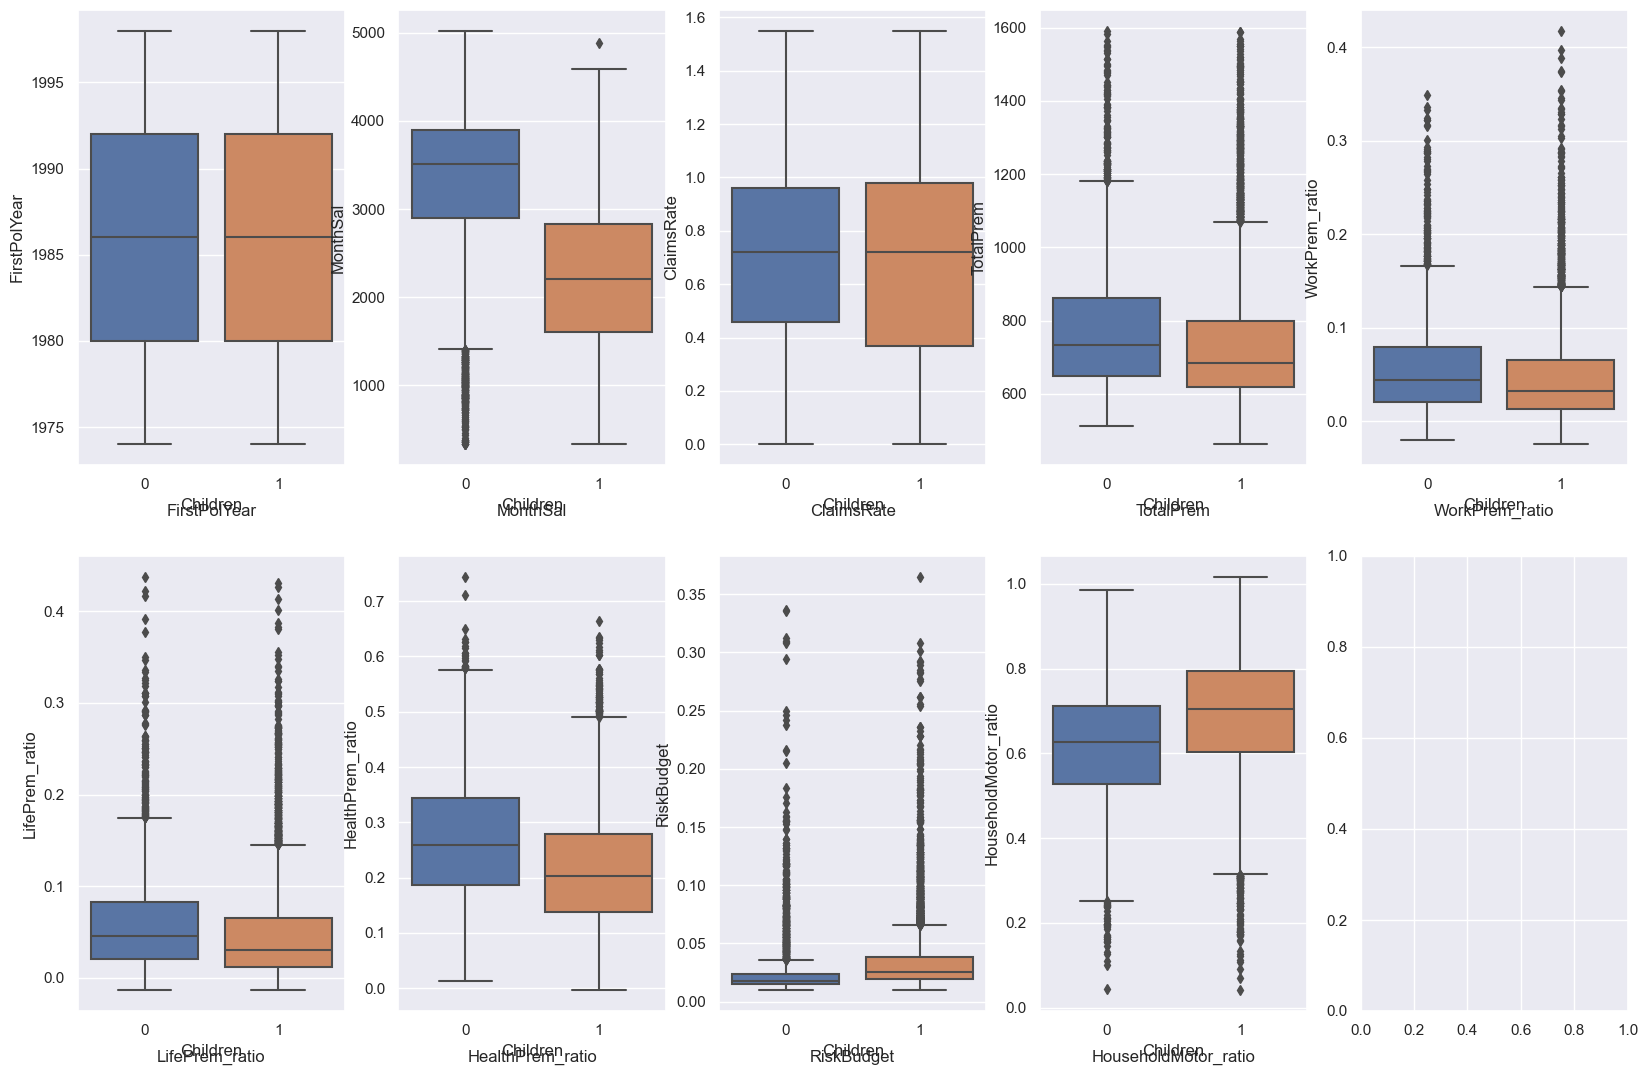

In [482]:
fig, axes = plt.subplots(2, int(np.ceil(len(numerical_col_list) / 2)), figsize=(20, 13))
	
# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), numerical_col_list): # Notice the zip() function and flatten() method
    # CODE HERE
    sns.boxplot(
        x = df_wo_out_clean['Children'],
        y = df_wo_out_clean[feat],
        ax = ax)
    ax.set_title(feat,y=-.13)
	    

#### Education

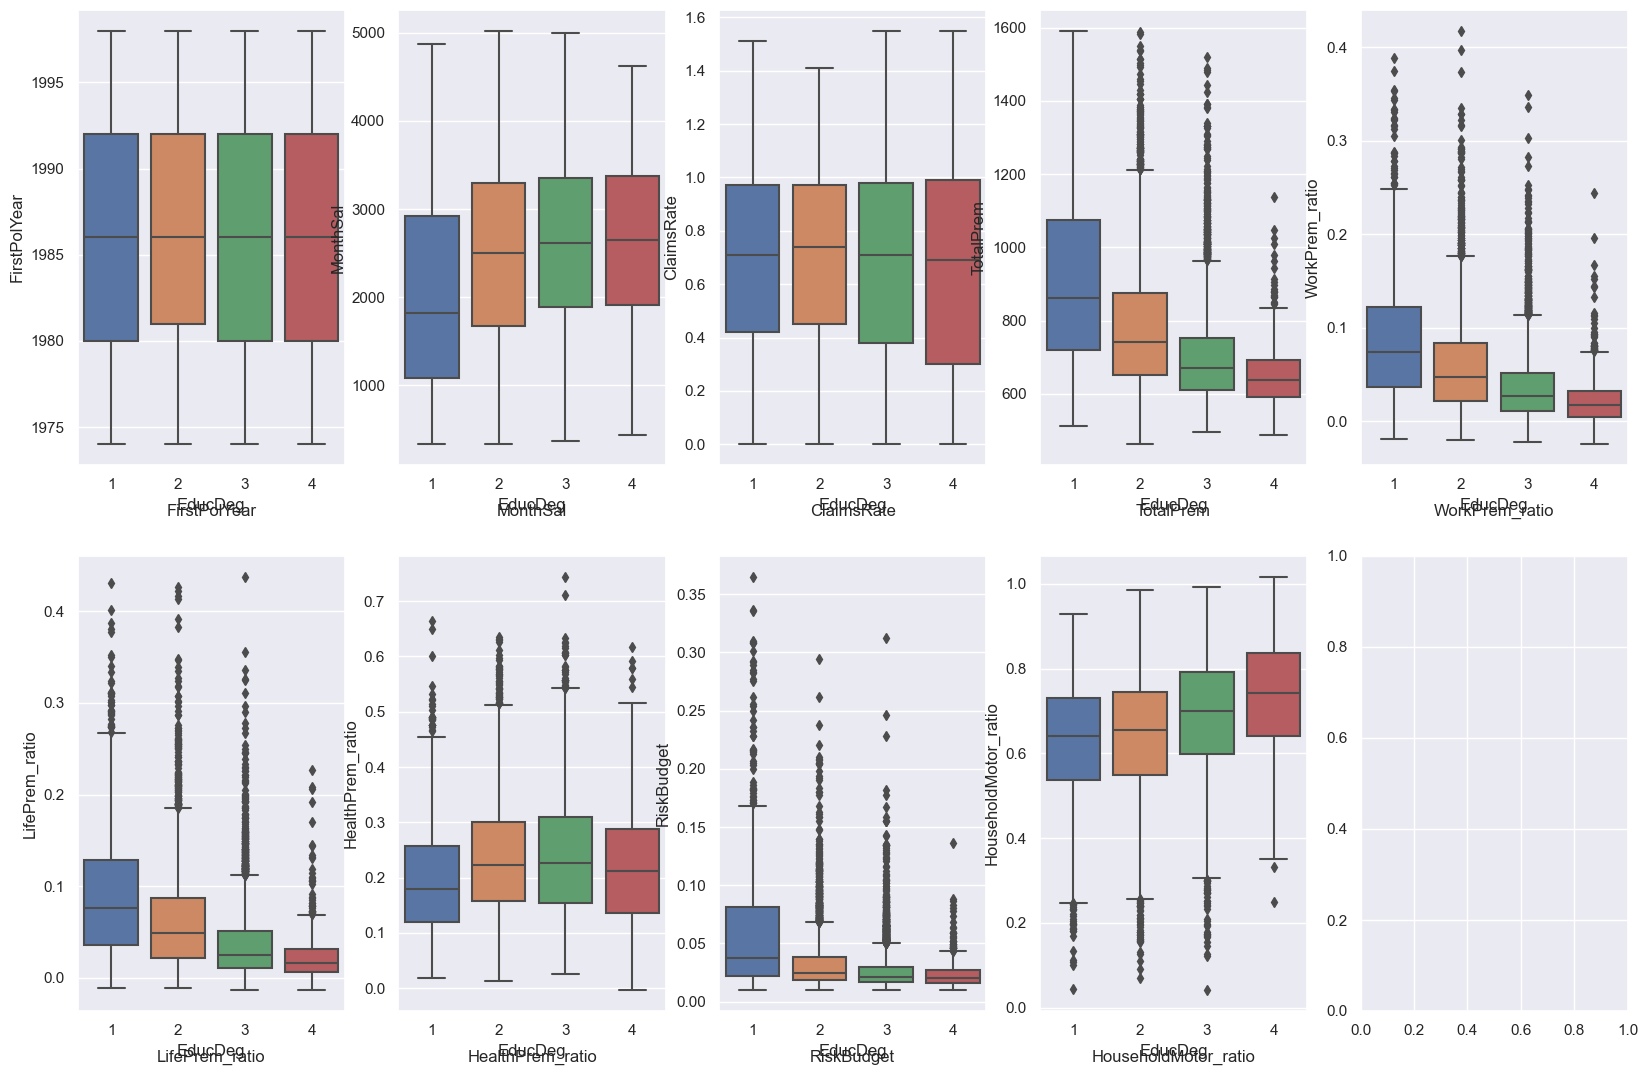

In [483]:
fig, axes = plt.subplots(2, int(np.ceil(len(numerical_col_list) / 2)), figsize=(20, 13))
	
# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), numerical_col_list): # Notice the zip() function and flatten() method
    # CODE HERE
    sns.boxplot(
        x = df_wo_out_clean['EducDeg'],
        y = df_wo_out_clean[feat],
        ax = ax)
    ax.set_title(feat,y=-.13)
	    

In [485]:
#Looks like Area variable is not very useful. It does not provide any kind of discrimination on the numerical values. We can drop it.
df_wo_out_clean = df_wo_out_clean.drop(['GeoLivArea'], axis=1)
#Update the list of the categorical columns
categorical_col_list = [col for col in categorical_col_list if col not in ['GeoLivArea']]

print("Numerical columns: ", numerical_col_list)
print("Ordinal columns: ", ordinal_col_list)
print("Categorical columns: ", categorical_col_list)
print("Final dataset shape", df_wo_out_clean.shape)

Numerical columns:  ['FirstPolYear', 'MonthSal', 'ClaimsRate', 'TotalPrem', 'WorkPrem_ratio', 'LifePrem_ratio', 'HealthPrem_ratio', 'RiskBudget', 'HouseholdMotor_ratio']
Ordinal columns:  ['EducDeg', 'has_cancelled']
Categorical columns:  ['EducDeg', 'Children', 'has_cancelled']
Final dataset shape (10060, 12)


## Final Data

In [513]:
# Data transformation
# We will use the StandardScaler to transform the numerical features and the OneHotEncoder to transform the categorical features.
# We will use the ColumnTransformer to apply the transformations to the respective columns.
# We will use the Pipeline to apply the transformations and the model in a single step.

#Pipeline to transform features
transform_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
                                        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_col_list),
                                        ('scaller', MinMaxScaler(), numerical_col_list)
                                        ], remainder='passthrough'))
    ])

# Transform the features
df_final = transform_pipeline.fit_transform(df_wo_out_clean)

# Convert the transformed features to a dataframe
columns = list(transform_pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out())
columns = columns + numerical_col_list
df_final = pd.DataFrame(df_final, columns=columns)
df_final.drop(['has_cancelled_0','Children_0'], axis=1, inplace=True)
df_final = df_final.rename(columns = {
    'has_cancelled_1': 'has_cancelled',
    'Children_1': 'Children'
})


In [514]:
df_final.head()

,EducDeg_1,EducDeg_2,EducDeg_3,EducDeg_4,Children,has_cancelled,FirstPolYear,MonthSal,ClaimsRate,TotalPrem,WorkPrem_ratio,LifePrem_ratio,HealthPrem_ratio,RiskBudget,HouseholdMotor_ratio
0,0.0,1.0,0.0,0.0,1.0,0.0,0.458333,0.393345,0.251613,0.180259,0.113131,0.186429,0.299050,0.044158,0.658924
1,0.0,1.0,0.0,0.0,1.0,0.0,0.291667,0.073379,0.722581,0.397483,0.319042,0.503141,0.176346,0.288069,0.513284
2,1.0,0.0,0.0,0.0,0.0,0.0,0.708333,0.414676,0.180645,0.246683,0.357906,0.288327,0.229966,0.048738,0.553825
3,0.0,0.0,1.0,0.0,1.0,0.0,0.666667,0.163396,0.638710,0.122828,0.162397,0.160271,0.697493,0.100651,0.343282
4,0.0,0.0,1.0,0.0,1.0,0.0,0.500000,0.305034,0.580645,0.148109,0.204637,0.096005,0.392966,0.056165,0.587238


# Models